### policy对创作者的影响，有无policy前后对比

#### 一. 充电专属政策有激励创作者进行更多创作吗

1. 对比policy前后创作者total video数量/month的变化，total video duration/month变化

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Load processed data
df = pd.read_parquet("../data/processed/processed_videos.parquet")

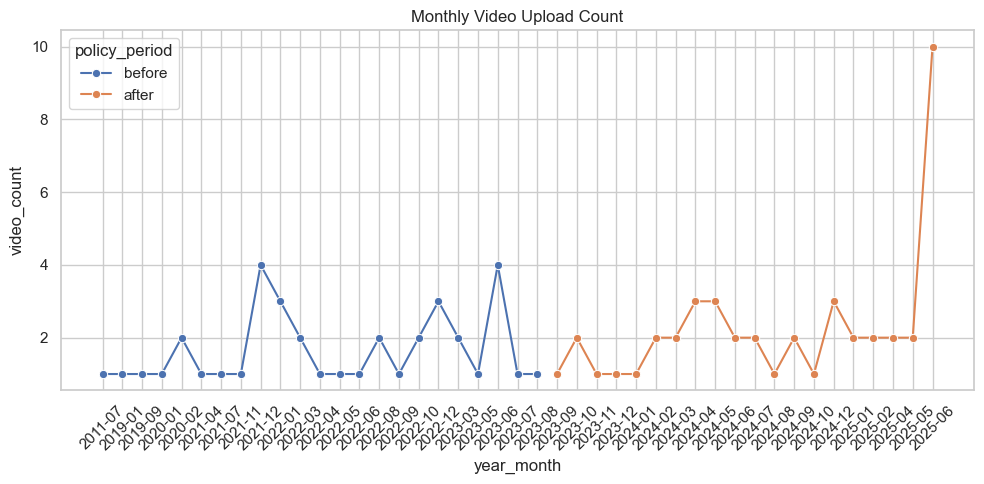

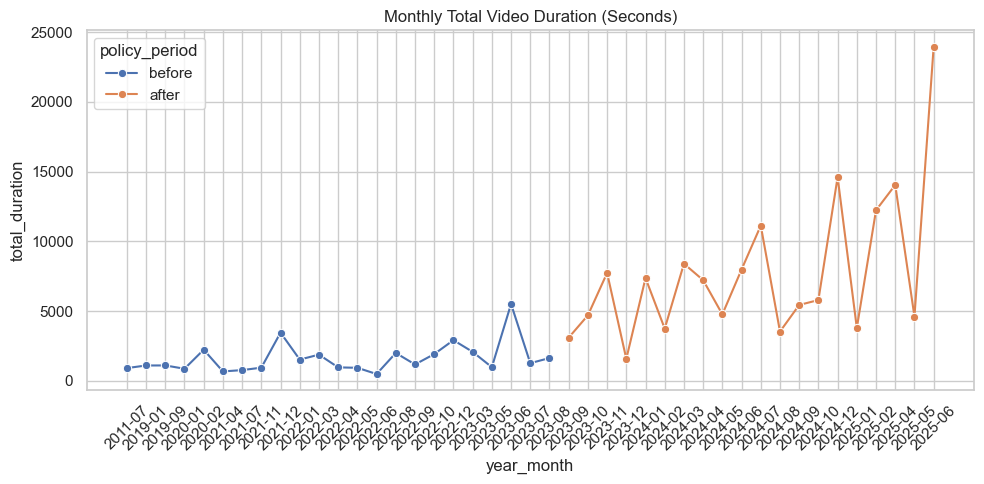

In [48]:
# 📊 Task 1: Policy Impact on Upload Volume & Duration

# Create "policy_period" label
df["policy_period"] = df["after_policy"].map({True: "after", False: "before"})

# Group by year_month and policy period
monthly_stats = df.groupby(["year_month", "policy_period"]).agg(
    video_count=("bv", "count"),
    total_duration=("duration", "sum")
).reset_index()

# Plot: Monthly video count
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="video_count", hue="policy_period", marker="o")
plt.title("Monthly Video Upload Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Monthly total duration
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="total_duration", hue="policy_period", marker="o")
plt.title("Monthly Total Video Duration (Seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. 每月充电视频比例变化

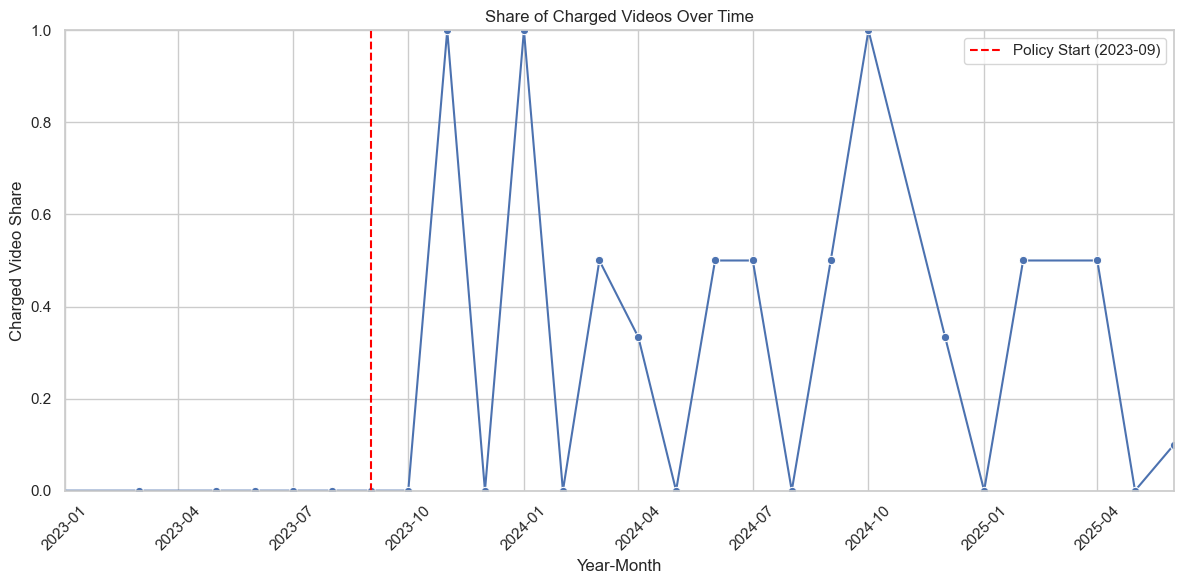

In [49]:
# Ensure datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format="%Y-%m")
monthly_charged_stats.index = pd.to_datetime(monthly_charged_stats.index)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_charged_stats, x=monthly_charged_stats.index, y='charged_share', marker='o')
plt.axvline(pd.to_datetime("2023-09-01"), color="red", linestyle="--", label="Policy Start (2023-09)")
plt.title("Share of Charged Videos Over Time")
plt.ylabel("Charged Video Share")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.xlim(pd.to_datetime("2023-01-01"), df['year_month'].max())  # <-- x-axis range
plt.legend()
plt.tight_layout()
plt.show()
